1. Загрузите данные, объедините источники в один датафрейм. Составьте целевую переменную на основе файла, из которого вы получили часть данных (бинарный признак, принимающий значение 1 для данных из файла про красное вино и 0 для данных из файла про белое вино), изучите распределение по ней. Проверьте отсутствие пропусков в данных, отделите фичи и целевой признак друг от друга, разделите данные на обучающую и валидационную части.
2. Поскольку выборка несбалансирована, воспользуемся для оценки качества модели новой метрикой balanced_accuracy_score. Изучите формулу расчета метрики в документации и реализуйте функцию balanced_accuracy_score_my для ее расчета. На вход она должна принимать правильные и прогнозные метки классов, а возвращать число от 0 до 1. Убедитесь, что вы корректно реализовали расчет, сравнив значения, получаемые библиотечной реализацией и собственной, подавая на вход векторы:
    ```
    y_true =  [0, 1, 1, 1, 1, 1, 1, 0, 1]
    y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]
    ```
3. Подберите лучшую модель решающего дерева:
    - Переберите несколько значений какого-либо гиперпараметра, отвечающего за сложность дерева, для каждого значения оцените качество на обучающей и валидационной частях;
    - Визуализируйте зависимость качества модели от значения гиперпараметров. Опишите зоны недообучения и переобучения, если вы их наблюдаете;
    - Выведите значение гиперпараметра, при котором качество модели на валидационной части наилучшее. 
4. Подберите лучшую модель случайного леса:
    - Переберите несколько значений какого-либо гиперпараметра дерева и для каждого из них — несколько значений гиперпараметра, отвечающего за количество решающих деревьев в случайном лесу. Для каждой комбинации гиперпараметров оцените качество на валидационной части.
    - Визуализируйте зависимость качества модели от значений гиперпараметров с помощью функции imshow. Опишите особенности, которые вы наблюдаете.
    - Выведите значения гиперпараметров, при которых качество модели на валидационной части выборки наилучшее.
5. Подберите лучший вариант градиентного бустинга:
    - Выделите из обучающей части данных часть для валидации градиентного бустинга в ходе обучения.
    - Зафиксируйте небольшое количество деревьев, значение какого-либо параметра, отвечающего за сложность решающих деревьев и значение величины шага градиентного бустинга. Обучите градиентный бустинг с выбранными параметрами, выводя в процессе обучения значение функции потерь на обучающей и валидационной частях. Выведите значение метрики качества на экран.
    - На фиксированном небольшом количестве деревьев сравните 3-4 комбинации значений параметров величины шага градиентного бустинга и какого-либо параметра, отвечающего за сложность решающих деревьев.
    - Выберите из рассмотренных комбинаций лучшую и обоснуйте свой выбор.
    - Увеличьте количество деревьев и опишите эффект. Изучите значение гиперпараметра early_stopping_rounds и воспользуйтесь им, чтобы сэкономить время, войдя в переобучение модели.\
В выводах напишите, какая модель показала себя лучше всего, какого качества удалось достичь.

In [1]:
import numpy as np
import pandas as pd
import io
import zipfile
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    log_loss
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### 1. Загрузите данные, объедините источники в один датафрейм.

Составьте целевую переменную на основе файла, из которого вы получили часть данных (бинарный признак, принимающий значение 1 для данных из файла про красное вино и 0 для данных из файла про белое вино), изучите распределение по ней. Проверьте отсутствие пропусков в данных, отделите фичи и целевой признак друг от друга, разделите данные на обучающую и валидационную части.

In [2]:
try:
    archive = zipfile.ZipFile("wine+quality.zip", "r")
    files_list = [i.filename for i in archive.filelist if i.filename.endswith(".csv")]
    print(files_list)
    for i in range(len(files_list)):
        txtdata = archive.read(files_list[i])
        locals()[f"df_{i}"] = pd.read_csv(io.BytesIO(txtdata), sep=";")
except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

['winequality-red.csv', 'winequality-white.csv']


In [3]:
df_0.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df_1.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Составим целевую переменную по цвету вина: 1 - красное, 0 - белое. 

In [5]:
df_0["target"] = 1
df_1["target"] = 0

In [6]:
df = pd.concat([df_0, df_1], ignore_index=True)

Проверим, верно ли соединились датафреймы.

In [7]:
print(f"df shape: {df.shape}, df_0 shape: {df_0.shape}, df_1 shape: {df_1.shape}")

df shape: (6497, 13), df_0 shape: (1599, 13), df_1 shape: (4898, 13)


In [8]:
df.tail(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  target                6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


Все столбцы числовые: 11 - float,  2 - int.

In [10]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")
df.drop_duplicates(inplace=True)

Количество дубликатов: 1177


In [11]:
df.shape

(5320, 13)

После удаления дубликатов осталось 5320 строк.

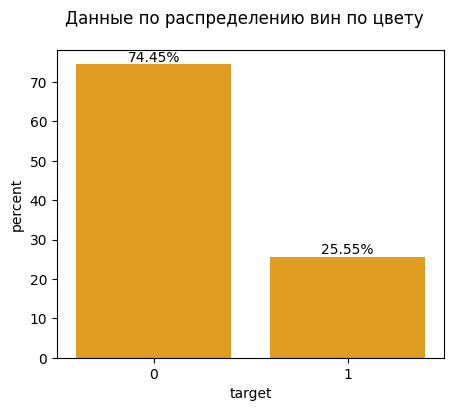

In [12]:
plt.figure(figsize=[5, 4])
plt.suptitle("Данные по распределению вин по цвету")
ax = sns.countplot(x=df.target, color="orange", stat="percent")
ax.bar_label(ax.containers[0], fmt="%.2f%%")
plt.show()

Вывод: красных вин в датасете представлено меньше, чем белых в 3 раза.

In [13]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
target                  0
dtype: int64

Пропусков в датасете нет. 

Разделим данные на обучающую и валидационную части.

In [14]:
X = df.drop(["target"], axis=1)
y = df.target

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

#### 2. Реализуйте функцию balanced_accuracy_score_my.

 На вход она должна принимать правильные и прогнозные метки классов, а возвращать число от 0 до 1. Убедитесь, что вы корректно реализовали расчет, сравнив значения, получаемые библиотечной реализацией и собственной, подавая на вход векторы:
 ```
y_true =  [0, 1, 1, 1, 1, 1, 1, 0, 1]
y_pred = [1, 0, 1, 1, 1, 1, 0, 0, 1]
```

In [16]:
y_true = [0, 1, 0, 0, 1, 0]
y_pred = [0, 1, 0, 0, 0, 1]

In [17]:
def balanced_accuracy_score_my(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP, TN, FN, FP = cm[0][0], cm[1][1], cm[0][1], cm[1][0]
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    return (TPR + TNR) / 2

In [18]:
print(
    f"Built-in balanced accuracy score={balanced_accuracy_score(y_true, y_pred)},\n\
custom balanced accuracy score={balanced_accuracy_score_my(y_true, y_pred)}"
)

Built-in balanced accuracy score=0.625,
custom balanced accuracy score=0.625


Вывод: кастомная фунция balanced accuracy score дает результат, как библиотечная.\
(библиотечная тоже написана на матрице, только другими методыми).

#### 3. Подберите лучшую модель решающего дерева.

3.1. Переберите несколько значений какого-либо гиперпараметра, отвечающего за сложность дерева, для каждого значения оцените качество на обучающей и валидационной частях

In [19]:
for criterion in ["gini", "entropy", "log_loss"]:
    model = DecisionTreeClassifier(criterion=criterion, random_state=123)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(
        f"{criterion}:\nТочность на обучающей выборке: {round(balanced_accuracy_score(y_train, y_pred_train), 6)}\n"
        f"Точность на валидационной выборке: {round(balanced_accuracy_score(y_test, y_pred_test), 6)}",
    )
    print("_____________")

gini:
Точность на обучающей выборке: 0.999481
Точность на валидационной выборке: 0.973965
_____________
entropy:
Точность на обучающей выборке: 0.999481
Точность на валидационной выборке: 0.978586
_____________
log_loss:
Точность на обучающей выборке: 0.999481
Точность на валидационной выборке: 0.978586
_____________


Лучший результат при использовании гиперпараметра "критерий": entropy и log_loss.

Создадим класс AccuracyMetric для удобства получения данных по модели.

In [20]:
class AccuracyMetric:

    def __init__(self, model, X_train, y_train, X_test, y_test) -> None:
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def get_accuracy_test(self):
        """
        Function for get balanced accuracy metrics for test data.
        """
        self.model.fit(self.X_train, self.y_train)
        y_pred_test = self.model.predict(self.X_test)
        return round(balanced_accuracy_score(self.y_test, y_pred_test), 6)

    def get_all_accuracy(self):
        """
        Function for get balanced accuracy metrics for train and test data.
        """
        self.model.fit(self.X_train, self.y_train)
        y_pred_train = self.model.predict(self.X_train)
        y_pred_test = self.model.predict(X_test)
        return (
            round(balanced_accuracy_score(self.y_train, y_pred_train), 6),
            round(balanced_accuracy_score(self.y_test, y_pred_test), 6),
        )

    def get_parametres(self):
        params = str(model.get_params)
        start = params.find("(") + 1
        end = params.rfind(")")
        return params[start:end]

    def print_all_metrics(self) -> str:
        accuracy_train, accuracy_test = self.get_all_accuracy()
        params = self.get_parametres()
        print(
            f"Параметры модели: {params}\n"
            f"Точность на обучающей выборке: {accuracy_train}\n"
            f"Точность на валидационной выборке: {accuracy_test}"
        )

    def print_test_metrica(self) -> str:
        accuracy_test = self.get_accuracy_test()
        params = self.get_parametres()
        print(
            f"Параметры модели: {params}\n"
            f"Точность на валидационной выборке: {accuracy_test}",
        )

3.2. Визуализируйте зависимость качества модели от значения гиперпараметров. \
Опишите зоны недообучения и переобучения, если вы их наблюдаете.

В модели будем использовать два постоянных гиперпараметра:
- критерий log_loss, так как он уже показал хороший результат на данных;
-  random_state, чтоб генерируемые псевдослучайные величины имели одни и те же значения при каждом вызове.\
 
Будем перебирать значения следующих гиперпараметров:
- минимальное количество объектов для разделения узла (min_samples_split);
- глубина дерева (max_depth);
- минимальное число объектов в листьях (min_samples_leaf).

In [21]:
# определим гиперпараметры
min_samples_split = range(2, 10)
depths = range(1, 51, 3)
min_samples_leaf = range(1, 10)

In [22]:
result = []
for depth in depths:
    model = DecisionTreeClassifier(
        max_depth=depth, criterion="log_loss", random_state=123
    )
    accuracy_train, accuracy_test = AccuracyMetric(
        model, X_train, y_train, X_test, y_test
    ).get_all_accuracy()
    result.append([depth, accuracy_train, accuracy_test])
result = pd.DataFrame(result, columns=["depth", "accuracy_train", "accuracy_test"])

In [23]:
result[result.accuracy_test == result.accuracy_test.max()]

,depth,accuracy_train,accuracy_test
3,10,0.998442,0.980682


In [24]:
# parametrs for plot
color_1 = "red"
color_2 = "green"
marker = "o"
markersize = 6
linestyle = "dashdot"
linewidth = 2

In [25]:
def visualization(title: str, param: str):
    """
    Function for visualize accuracy metrica.
    """
    plt.figure(figsize=(6, 4))
    plt.title(title)
    result.set_index(param)["accuracy_train"].plot(
        label="accuracy_train",
        color=color_1,
        linewidth=linewidth,
        markersize=markersize,
        linestyle=linestyle,
        marker=marker,
    )
    result.set_index(param)["accuracy_test"].plot(
        label="accuracy_test",
        color=color_2,
        linewidth=linewidth,
        markersize=markersize,
        linestyle=linestyle,
        marker=marker,
    )
    plt.legend()
    plt.ylabel("Accuracy")
    plt.show()

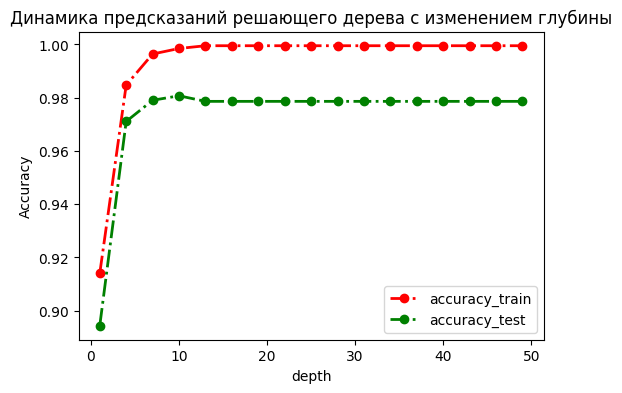

In [26]:
visualization("Динамика предсказаний решающего дерева с изменением глубины", "depth")

Лучший результат показывает дерево с глубиной 10 - 0.9984 train, 0.9806 test.\
Затем модель начинает переобучаться, и результат становится несколько ниже.

In [27]:
result = []
for samples in min_samples_split:
    model = DecisionTreeClassifier(
        max_depth=10, random_state=123, min_samples_split=samples, criterion="log_loss"
    )
    accuracy_train, accuracy_test = AccuracyMetric(
        model, X_train, y_train, X_test, y_test
    ).get_all_accuracy()
    result.append([samples, accuracy_train, accuracy_test])
result = pd.DataFrame(result, columns=["samples", "accuracy_train", "accuracy_test"])

In [28]:
result[result.accuracy_test == result.accuracy_test.max()]

,samples,accuracy_train,accuracy_test
4,6,0.996704,0.981515
5,7,0.996704,0.981515


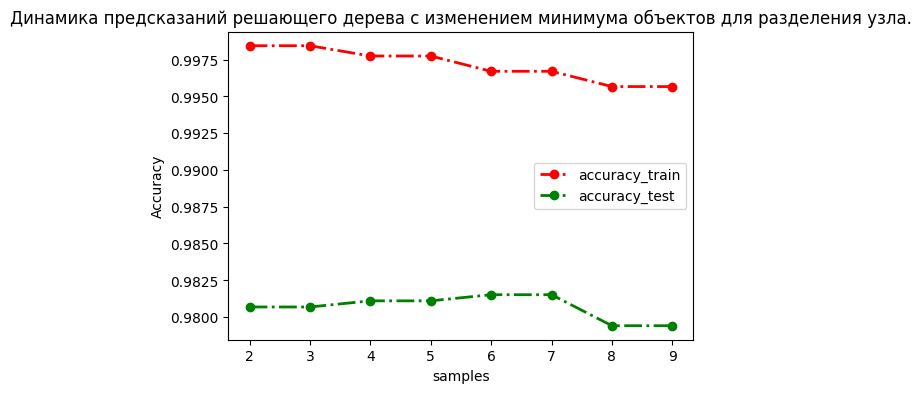

In [29]:
visualization(
    "Динамика предсказаний решающего дерева с изменением минимума объектов для разделения узла.",
    "samples",
)

Лучший результат показывает дерево с минимумальным количеством 6 объектов для разделения узла - 0.9967 train, 0.9815 test.\
С увеличением минимума объектов значение метрики падает на обеих выборках.

In [30]:
result = []
for samples in min_samples_leaf:
    model = DecisionTreeClassifier(
        max_depth=10,
        random_state=123,
        min_samples_split=6,
        criterion="log_loss",
        min_samples_leaf=samples,
    )
    accuracy_train, accuracy_test = AccuracyMetric(
        model, X_train, y_train, X_test, y_test
    ).get_all_accuracy()
    result.append([samples, accuracy_train, accuracy_test])
result = pd.DataFrame(result, columns=["samples", "accuracy_train", "accuracy_test"])

In [31]:
result[result.accuracy_test == result.accuracy_test.max()]

,samples,accuracy_train,accuracy_test
0,1,0.996704,0.981515
3,4,0.991306,0.981515


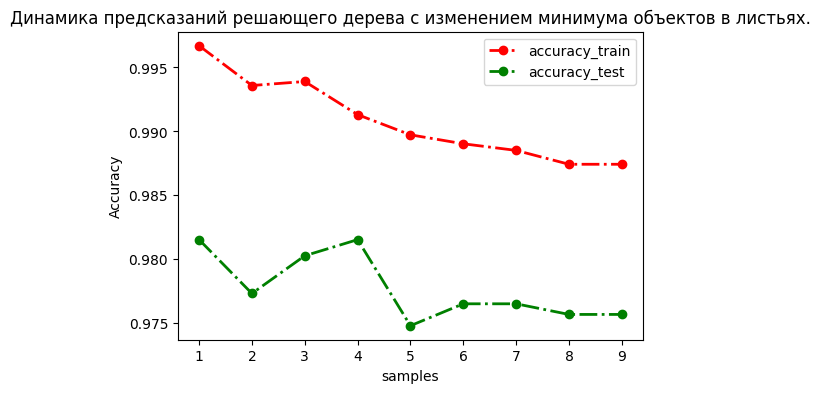

In [32]:
visualization(
    "Динамика предсказаний решающего дерева с изменением минимума объектов в листьях.",
    "samples",
)

Лучший результат показывает дерево с минимум одним объектом в каждом листе: - 0.9967 train, 0.9815 test.\
С увеличением минимума объектов метрика снижается на обеих выборках.

3.3. Выведите значение гиперпараметра, при котором качество модели на валидационной части наилучшее. 

In [33]:
# запустим лучшую модель
model = DecisionTreeClassifier(
    max_depth=10,
    random_state=123,
    min_samples_split=6,
    criterion="log_loss",
    min_samples_leaf=4,
)
accuracy_ = AccuracyMetric(model, X_train, y_train, X_test, y_test)
accuracy_test = accuracy_.get_accuracy_test()
accuracy_.print_all_metrics()

Параметры модели: criterion='log_loss', max_depth=10, min_samples_leaf=4,
                       min_samples_split=6, random_state=123
Точность на обучающей выборке: 0.991306
Точность на валидационной выборке: 0.981515


In [34]:
# запишем лучший результат
total_result = {}
total_result.setdefault('DecisionTreeClassifier', accuracy_test)

np.float64(0.981515)

#### 4. Подберите лучшую модель случайного леса:

4.1. Переберите несколько значений какого-либо гиперпараметра дерева и для каждого из них — несколько значений гиперпараметра, отвечающего за количество решающих деревьев в случайном лесу. Для каждой комбинации гиперпараметров оцените качество на валидационной части.

В модели будем использовать два постоянных гиперпараметра:
- параллельное построение деревьев и параллельное вычисление прогнозов с помощью n_jobs.\
 Если n_jobs=-1 тогда используются все ядра, имеющиеся на машине.
 -  random_state, чтоб генерируемые псевдослучайные величины имели одни и те же значения при каждом вызове.\
 
Будем перебирать значения следующих гиперпараметров:
- минимальное количество объектов для разделения узла (min_samples_split)
- глубина дерева (max_depth)
- максимальное количество листьев (max_leaf_nodes)

In [35]:
# определим гиперпараметры
min_samples_split = range(2, 10)
estimators = range(1, 202, 20)
depths = range(1, 20, 2)
max_leaf_nodes = range(2, 52, 10)

In [36]:
result_samples = []
for samples in min_samples_split:
    for estimator in estimators:
        model = RandomForestClassifier(
            random_state=123,
            n_estimators=estimator,
            min_samples_split=samples,
            n_jobs=-1,
        )
        accuracy_ = AccuracyMetric(model, X_train, y_train, X_test, y_test)
        result_samples.append((samples, estimator, accuracy_.get_accuracy_test()))
result_samples = pd.DataFrame(
    result_samples, columns=["samples", "estimator", "accuracy_test"]
)

Посмотрим на лучший результат с минимальным значением параметра min_samples_split.

In [37]:
samples = (
    result_samples[result_samples.accuracy_test == result_samples.accuracy_test.max()]
    .sort_values(by="samples")
    .iloc[0]
)
samples

samples           5.000000
estimator        21.000000
accuracy_test     0.989912
Name: 34, dtype: float64

Создадим словарь для лучших значений.

In [38]:
result_dict = {}
result_dict.setdefault("Accuracy", []).append(samples.accuracy_test)
result_dict.setdefault("Estimators", []).append(samples.estimator)
result_dict.setdefault("Parameter", []).append(samples.samples)

In [39]:
result_depth = []
for depth in depths:
    for estimator in estimators:
        model = RandomForestClassifier(
            random_state=123,
            n_estimators=estimator,
            max_depth=depth,
            n_jobs=-1
        )
        accuracy_ = AccuracyMetric(model, X_train, y_train, X_test, y_test)
        result_depth.append((depth, estimator, accuracy_.get_accuracy_test()))
result_depth = pd.DataFrame(
    result_depth, columns=["depth", "estimator", "accuracy_test"]
)

Посмотрим на лучший результат с минимальным значением параметра max_depth.

In [40]:
depth = (
    result_depth[result_depth.accuracy_test == result_depth.accuracy_test.max()]
    .sort_values(by="depth")
    .iloc[0]
)
depth

depth             7.000000
estimator        81.000000
accuracy_test     0.989482
Name: 37, dtype: float64

In [41]:
result_dict.setdefault("Accuracy", []).append(depth.accuracy_test)
result_dict.setdefault("Estimators", []).append(depth.estimator)
result_dict.setdefault("Parameter", []).append(depth.depth)

In [42]:
result_nodes = []
for leaf_nodes in max_leaf_nodes:
    for estimator in estimators:
        model = RandomForestClassifier(
            random_state=123,
            n_estimators=estimator,
            max_leaf_nodes=leaf_nodes,
            n_jobs=-1
        )
        accuracy_ = AccuracyMetric(model, X_train, y_train, X_test, y_test)
        result_nodes.append((leaf_nodes, estimator, accuracy_.get_accuracy_test()))
result_nodes = pd.DataFrame(
    result_nodes, columns=["leaf_nodes", "estimator", "accuracy_test"]
)

Посмотрим на лучший результат с минимальным значением параметра max_leaf_nodes.

In [43]:
nodes = (
    result_nodes[result_nodes.accuracy_test == result_nodes.accuracy_test.max()]
    .sort_values(by="leaf_nodes")
    .iloc[0]
)
result_dict.setdefault("Accuracy", []).append(nodes.accuracy_test)
result_dict.setdefault("Estimators", []).append(nodes.estimator)
result_dict.setdefault("Parameter", []).append(nodes.leaf_nodes)
nodes

leaf_nodes        42.000000
estimator        141.000000
accuracy_test      0.987803
Name: 51, dtype: float64

4.2. Визуализируйте зависимость качества модели от значений гиперпараметров с помощью функции imshow.\
Опишите особенности, которые вы наблюдаете.

In [44]:
# создание индексов для построения графиков
min_samples_split_idx = np.arange(len(min_samples_split))
estimators_idx = np.arange(len(estimators))
depths_idx = np.arange(len(depths))
max_leaf_nodes_idx = np.arange(len(max_leaf_nodes))

In [45]:
# перевод данных в двумерных массив для работы с imshow
data = np.array(result_depth.accuracy_test).reshape(len(depths), len(estimators))

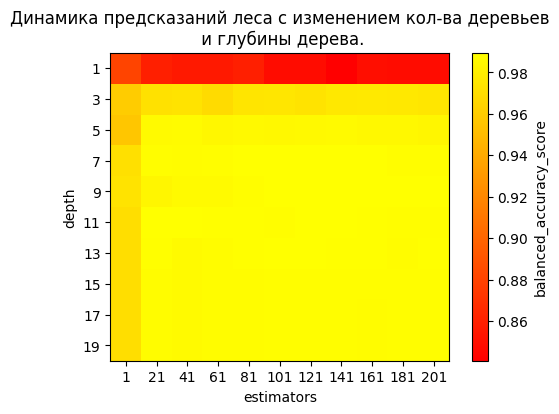

In [46]:
plt.figure(figsize=(6, 4))
plt.title("Динамика предсказаний леса с изменением кол-ва деревьев\n и глубины дерева.")
plt.imshow(data, interpolation="nearest", cmap="autumn")
plt.xlabel("estimators")
plt.ylabel("depth")
plt.colorbar(label="balanced_accuracy_score")
plt.yticks(depths_idx, depths)
plt.xticks(estimators_idx, estimators)
plt.show()

На графике видно, как с увеличение глубины дерева растет метрика качества даже при минимальном кол-ве деревьев.\
Увеличение кол-ва деревьев работает вместе с их глубиной.\
По графику начиная от глубины 11 лучший результат достигается уже на 21 дереве.

In [47]:
data = np.array(result_samples.accuracy_test).reshape(
    len(min_samples_split), len(estimators)
)

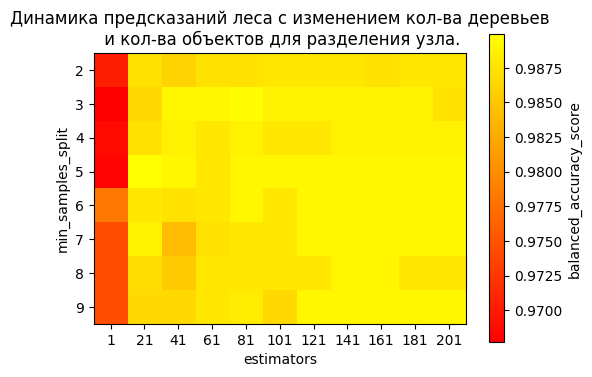

In [48]:
plt.figure(figsize=(6, 4))
plt.title(
    "Динамика предсказаний леса с изменением кол-ва деревьев\n и кол-ва объектов для разделения узла."
)
plt.imshow(data, interpolation="nearest", cmap="autumn")
plt.xlabel("estimators")
plt.ylabel("min_samples_split")
plt.colorbar(label="balanced_accuracy_score")
plt.yticks(min_samples_split_idx, min_samples_split)
plt.xticks(estimators_idx, estimators)
plt.show()

На данном графике уже нет такой зависимости гиперпараметров. Мы видим, что увеличение кол-ва объектов для узла требует большего числа деревьев.
Лучший результат достигается уже на 21 дереве.

In [49]:
data = np.array(result_nodes.accuracy_test).reshape(
    len(max_leaf_nodes), len(estimators)
)

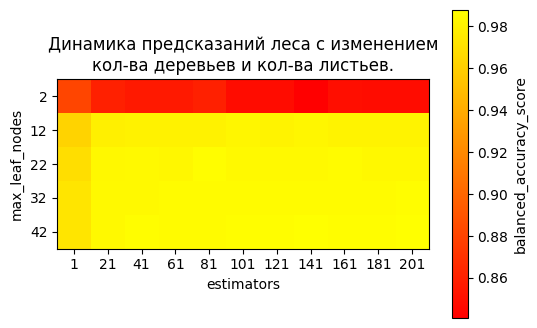

In [50]:
plt.figure(figsize=(6, 4))
plt.title("Динамика предсказаний леса с изменением\nкол-ва деревьев и кол-ва листьев.")
plt.imshow(data, interpolation="nearest", cmap="autumn")
plt.xlabel("estimators")
plt.ylabel("max_leaf_nodes")
plt.colorbar(label="balanced_accuracy_score")
plt.yticks(max_leaf_nodes_idx, max_leaf_nodes)
plt.xticks(estimators_idx, estimators)
plt.show()

На данном графике мы видим, что ограничение кол-ва листьев небольшими значениями уменьшает метрику.
Как и в прошлых случаях, все решает кол-во деревьев.\
Можно сделать вывод, что из исследуюемых трех гиперпараметров кол-во деревьев - самый важный.

4.3. Выведите значения гиперпараметров, при которых качество модели на валидационной части выборки наилучшее.

In [51]:
# сделаем датафрейм из словаря с лучшими значениями
columns = [
    "min_samples_split",
    "max_depth",
    "max_leaf_nodes",
]
metrics = pd.DataFrame(result_dict, columns)
metrics[["Estimators", "Parameter"]] = metrics[["Estimators", "Parameter"]].astype(
    "int16"
)
metrics

,Accuracy,Estimators,Parameter
min_samples_split,0.989912,21,5
max_depth,0.989482,81,7
max_leaf_nodes,0.987803,141,42


Переберем все варианты кол-ва деревьев.

In [52]:
result = []
for estimator in (metrics.Estimators).to_list():
    model = RandomForestClassifier(
        random_state=123,
        min_samples_split=5,
        max_depth=7,
        max_leaf_nodes=42,
        n_estimators=estimator,
        criterion='log_loss'
    )
    accuracy_ = AccuracyMetric(model, X_train, y_train, X_test, y_test)
    accuracy_ = AccuracyMetric(model, X_train, y_train, X_test, y_test)
    result.append(accuracy_.get_accuracy_test())
    accuracy_.print_test_metrica()
    print('--------------------')

Параметры модели: criterion='log_loss', max_depth=7, max_leaf_nodes=42,
                       min_samples_split=5, n_estimators=21, random_state=123
Точность на валидационной выборке: 0.98654
--------------------
Параметры модели: criterion='log_loss', max_depth=7, max_leaf_nodes=42,
                       min_samples_split=5, n_estimators=81, random_state=123
Точность на валидационной выборке: 0.988649
--------------------
Параметры модели: criterion='log_loss', max_depth=7, max_leaf_nodes=42,
                       min_samples_split=5, n_estimators=141, random_state=123
Точность на валидационной выборке: 0.989066
--------------------


Лучший результат показала модель со следующими гиперпараметрами:
- criterion='log_loss',
- max_depth=7,
- max_leaf_nodes=42,
- min_samples_split=5,
- n_estimators=141,
- random_state=123

Точность на валидационной выборке: 0.989066

In [53]:
total_result.setdefault('RandomForestClassifier', max(result))

np.float64(0.989066)

#### 5. Подберите лучший вариант градиентного бустинга:

5.1. Выделите из обучающей части данных часть для валидации градиентного бустинга в ходе обучения.

In [54]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0
)

5.2. Зафиксируйте небольшое количество деревьев, значение какого-либо параметра, отвечающего за сложность решающих деревьев и значение величины шага градиентного бустинга. Обучите градиентный бустинг с выбранными параметрами, выводя в процессе обучения значение функции потерь на обучающей и валидационной частях. Выведите значение метрики качества на экран.\
ВОПРОС: какая метрика имелась ввиду: точность или потеря?

In [55]:
model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=10)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
accuracy_train = balanced_accuracy_score(y_train, model.predict(X_train))
accuracy_val = balanced_accuracy_score(y_val, model.predict(X_val))

print(
    f"Точность на обучающей выборке: {round(accuracy_train, 6)}\n"
    f"Точность на валидационной выборке: {round(accuracy_val, 6)}\n"
)

[0]	validation_0-logloss:0.49284	validation_1-logloss:0.47439
[1]	validation_0-logloss:0.42860	validation_1-logloss:0.41521
[2]	validation_0-logloss:0.37715	validation_1-logloss:0.36784
[3]	validation_0-logloss:0.33460	validation_1-logloss:0.32899
[4]	validation_0-logloss:0.29859	validation_1-logloss:0.29503
[5]	validation_0-logloss:0.26743	validation_1-logloss:0.26521
[6]	validation_0-logloss:0.24066	validation_1-logloss:0.23954
[7]	validation_0-logloss:0.21728	validation_1-logloss:0.21721
[8]	validation_0-logloss:0.19683	validation_1-logloss:0.19781
[9]	validation_0-logloss:0.17864	validation_1-logloss:0.17978
Точность на обучающей выборке: 0.986303
Точность на валидационной выборке: 0.979619



Фунция потерь близка на обеих выборках, за 10 деревьев она снизилась с 0.49 до 0.17.

5.3. На фиксированном небольшом количестве деревьев сравните 3-4 комбинации значений параметров величины шага градиентного бустинга и какого-либо параметра, отвечающего за сложность решающих деревьев.\
5.4. Выберите из рассмотренных комбинаций лучшую и обоснуйте свой выбор.

In [56]:
# определим гиперпараметры
estimators = 10
depths = 2, 5
learning_rates = 0.1, 0.03

In [57]:
for depth in depths:
    for learning_rate in learning_rates:
        model = XGBClassifier(
            random_state=123,
            n_estimators=10,
            max_depth=depth,
            learning_rate=learning_rate,
        )
        model.fit(X_train, y_train)
        # функция потерь определяется на основании данных, полученных методом predict_proba
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        print(
            f"depth={depth}, learning_rate={learning_rate}\n"
            f"Функция потерь на валидационной выборке: {round(val_loss, 6)}"
        )
        print("-----------------")

depth=2, learning_rate=0.1
Функция потерь на валидационной выборке: 0.210528
-----------------
depth=2, learning_rate=0.03
Функция потерь на валидационной выборке: 0.388111
-----------------
depth=5, learning_rate=0.1
Функция потерь на валидационной выборке: 0.179776
-----------------
depth=5, learning_rate=0.03
Функция потерь на валидационной выборке: 0.374264
-----------------


Лучший результат функции потерь на валидационной выборке: 0.179776\
при комбинации depth=5, learning_rate=0.1

5.5. Увеличьте количество деревьев и опишите эффект.

In [58]:
model = XGBClassifier(
    random_state=123,
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    verbosity=1,
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [59]:
results = model.evals_result()
min_logloss = min(results['validation_1']['logloss'])
best_iteration = results['validation_1']['logloss'].index(min_logloss)
print(f'Минимальная функция потерь составляет {round(min_logloss, 6)} на {best_iteration} итерации.')

Минимальная функция потерь составляет 0.006483 на 298 итерации.


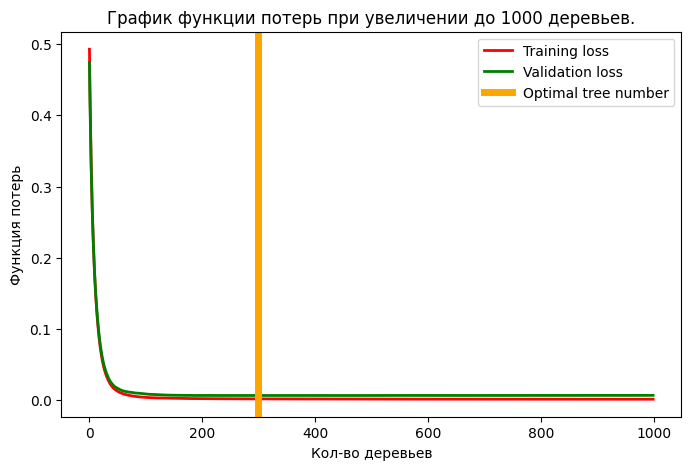

In [60]:
plt.figure(figsize=(8, 5))
plt.title("График функции потерь при увеличении до 1000 деревьев.")
plt.plot(
    results["validation_0"]["logloss"],
    label="Training loss",
    color=color_1,
    linewidth=linewidth,
)
plt.plot(
    results["validation_1"]["logloss"],
    label="Validation loss",
    color=color_2,
    linewidth=linewidth,
)
plt.axvline(best_iteration, color="orange", label="Optimal tree number", linewidth=5)
plt.xlabel("Кол-во деревьев")
plt.ylabel("Функция потерь")
plt.legend()
plt.show()

При увеличении количества деревьев появляется риск переобучения.\
Он хорошо виден на графике: фунция потерь на тренировочных и валидационных данных практически не изменяются.

5.5. Изучите значение гиперпараметра early_stopping_rounds и воспользуйтесь им, чтобы сэкономить время, войдя в переобучение модели.

In [61]:
model = XGBClassifier(
    random_state=123,
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    early_stopping_rounds=5,
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-logloss:0.49284	validation_1-logloss:0.47439
[1]	validation_0-logloss:0.42860	validation_1-logloss:0.41521
[2]	validation_0-logloss:0.37715	validation_1-logloss:0.36784
[3]	validation_0-logloss:0.33460	validation_1-logloss:0.32899
[4]	validation_0-logloss:0.29859	validation_1-logloss:0.29503
[5]	validation_0-logloss:0.26743	validation_1-logloss:0.26521
[6]	validation_0-logloss:0.24066	validation_1-logloss:0.23954
[7]	validation_0-logloss:0.21728	validation_1-logloss:0.21721
[8]	validation_0-logloss:0.19683	validation_1-logloss:0.19781
[9]	validation_0-logloss:0.17864	validation_1-logloss:0.17978
[10]	validation_0-logloss:0.16247	validation_1-logloss:0.16424
[11]	validation_0-logloss:0.14794	validation_1-logloss:0.15034
[12]	validation_0-logloss:0.13513	validation_1-logloss:0.13866
[13]	validation_0-logloss:0.12362	validation_1-logloss:0.12775
[14]	validation_0-logloss:0.11337	validation_1-logloss:0.11768
[15]	validation_0-logloss:0.10417	validation_1-logloss:0.10833
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

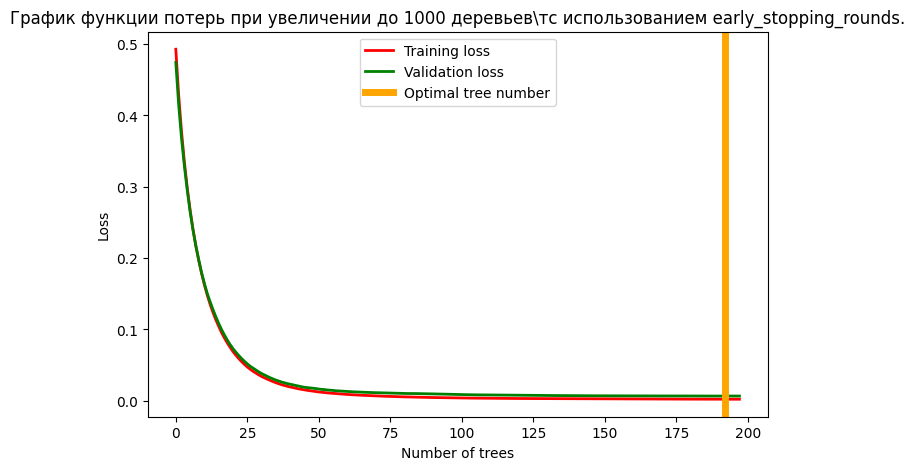

In [62]:
results = model.evals_result()

plt.figure(figsize=(8,5))
plt.title("График функции потерь при увеличении до 1000 деревьев\тс использованием early_stopping_rounds.")
plt.plot(results["validation_0"]["logloss"], label="Training loss", color=color_1, linewidth=linewidth)
plt.plot(results["validation_1"]["logloss"], label="Validation loss", color=color_2, linewidth=linewidth)
plt.axvline(model.best_iteration, color="orange", label="Optimal tree number", linewidth=5)
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [63]:
model.best_iteration

192

При добавлении гиперпараметра early_stopping_rounds, в данном случае равному 5 (так рекомендуется в литературе),\
мы получаем лучший результат при 192 итерации при заявленной 1000.

In [64]:
model = XGBClassifier(
    random_state=123,
    n_estimators=192,
    max_depth=5,
    learning_rate=0.1,
)
accuracy_ = AccuracyMetric(model, X_train, y_train, X_test, y_test)
accuracy_.print_test_metrica()

Параметры модели: base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=192, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...
Точность на валидационной выборке: 0.987803


In [65]:
accuracy_test = accuracy_.get_accuracy_test()
total_result.setdefault('XGBClassifier', accuracy_test)

np.float64(0.987803)

In [66]:
pd.DataFrame.from_dict(total_result, 'index', columns=['accuracy'])

,accuracy
DecisionTreeClassifier,0.981515
RandomForestClassifier,0.989066
XGBClassifier,0.987803


*Вывод*:\
Лучший результат показала модель RandomForestClassifier с результатом метрики balanced accuracy: 0.989066\
С гиперпараметрами работать необходимо для улучшения метрик.